# Flow Matching 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/NDE/flow_matching_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a flow-matching model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and density estimation using the pipeline utility.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [1]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [2]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install --quiet "gensbi[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI"
    %pip install --quiet "gensbi_examples @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone --depth 1 https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/NDE

In [3]:
# Set training and model restoration flags
overwrite_model = False
restore_model = False  # Use pretrained model if available
train_model = True  # Set to True to train from scratch

normalize_data = False

### Library Imports and JAX Backend Selection

In [4]:
# Import libraries and set JAX backend
import os
os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
# os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

from gensbi_dist import get_gensbi_samples

In [ ]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/gensbi_text_v2"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [6]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

from gensbi.utils.plotting import transparent_cmap

In [7]:
batch_size = 1024
factor = np.sqrt(batch_size/256)

data = get_gensbi_samples(n_samples=100_000)

mean = data.mean(axis=0)
std = data.std(axis=0)

def normalize(x):
    return (x - mean) / std

def unnormalize(x):
    return x * std + mean

In [8]:
# # Infinite data generator for training batches
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_boxes_jax(key, batch_size)

#     return x

if normalize_data:
    data = normalize(data)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
)

performance_config = grain.experimental.pick_performance_config(
            ds=train_dataset_grain,
            ram_budget_mb=1024 * 4,
            max_workers=None,
            max_buffer_size=None,
        )

train_dataset_batched = train_dataset_grain.batch(batch_size).mp_prefetch(
            performance_config.multiprocessing_options
        )

train_iter = iter(train_dataset_batched)

data_val = get_gensbi_samples(n_samples=1_000)
if normalize_data:
    data_val = normalize(data_val)


val_dataset_batched = (
    grain.MapDataset.source(np.array(data_val)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(512)
)

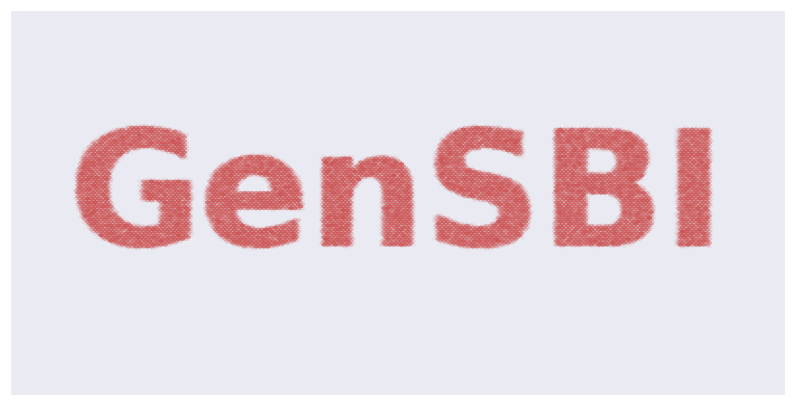

In [9]:
# # Visualize the generated data distribution
if normalize_data:
    samples = np.array(unnormalize(data))
else:
    samples = np.array(data)

def plot_samples(ax, samples):

    ax.hexbin( 
        samples[:, 0],
        samples[:, 1],
        gridsize=(200, 100),
        cmap=transparent_cmap,
        extent=[-2, 2, -1, 1],
    )

    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1)
    #hide axes
    ax.grid(None)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

fig, ax = plt.subplots(figsize=(10, 5))
plot_samples(ax, samples)
plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the flow-matching model.

In [10]:
# Import flow matching components and utilities
from gensbi.recipes import UnconditionalFlowPipeline
from gensbi.models import Flux1Joint, Flux1JointParams

/home/aure/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Define the MLP velocity field model
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs, n_layers=8):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.obs_in= nnx.Linear(din, self.hidden_dim, rngs=rngs)

        self.middle_layers = nnx.List([nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs) for i in range(n_layers-2)])

        self.out = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)
     

    def __call__(self, t: jax.Array, obs: jax.Array,  **kwargs):
        assert obs.ndim == 3, f"Input obs must have shape (batch_size, input_dim, 1), got {obs.shape}"
        t = jnp.atleast_1d(t)
        x = jnp.squeeze(obs, axis=-1)
        if t.ndim<2:
            t = t[..., None]

        t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
        h = jnp.concatenate([x, t], axis=-1)

        x = self.obs_in(h)
        x = jax.nn.gelu(x)

        for i in range(len(self.middle_layers)):
            x = self.middle_layers[i](x)
            x = jax.nn.gelu(x)

        x = self.out(x)

        return x[...,None]

In [12]:
# Initialize the velocity field model
hidden_dim = 512

# velocity field model init
model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

In [13]:
training_config = UnconditionalFlowPipeline.get_default_training_config()
training_config["checkpoint_dir"] = checkpoint_dir
training_config["nsteps"] = 100_000
training_config["max_lr"] = 1e-4 * factor
training_config["min_lr"] = 1e-6 * factor


pipeline = UnconditionalFlowPipeline(model,
    train_dataset_batched,
    val_dataset_batched,
    2,
    training_config=training_config)

In [14]:
# Restore the model from checkpoint if requested
if restore_model:
    pipeline.restore_model()

In [15]:
model_params = nnx.state(pipeline.model, nnx.Param)
total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(model_params))
print(f"Total model parameters: {total_params}")

Total model parameters: 1579010


## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [16]:
if train_model:
    # Train the model
    pipeline.train(nnx.Rngs(0))

100%|██████████| 100000/100000 [10:39<00:00, 156.32it/s, counter=0, loss=0.8668, ratio=1.0055, val_loss=0.8817]


Saved model to checkpoint


## 5. Sampling from the Model

In this section, we sample trajectories from the trained flow-matching model and visualize the results at different time steps.

### sample the model

In [17]:
key = jax.random.PRNGKey(42)
T = jnp.linspace(0,1,10)  # sample times
sol = pipeline.sample(key, nsamples=500_000, time_grid=T)

In [18]:
if normalize_data:
    samples = unnormalize(sol[-1,...,0])
else:
    samples = sol[-1,...,0]

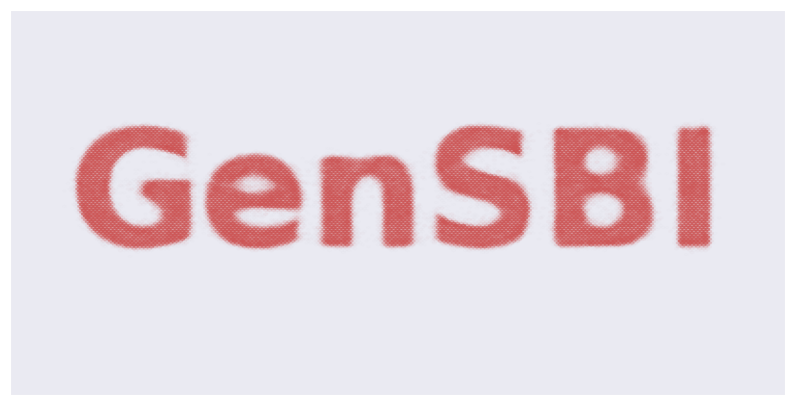

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_samples(ax, np.array(samples))
plt.show()

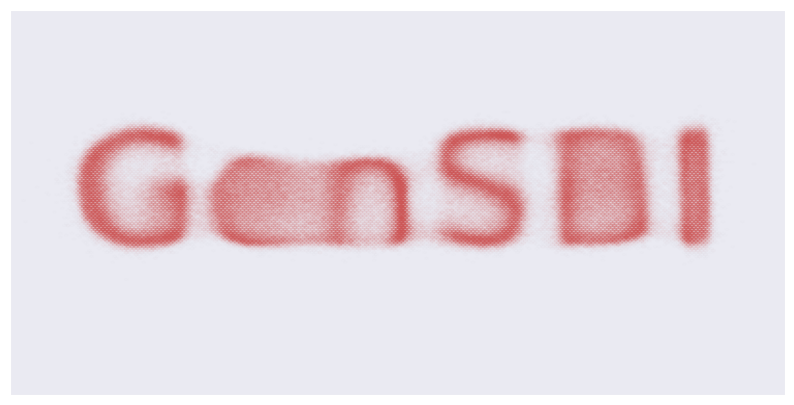

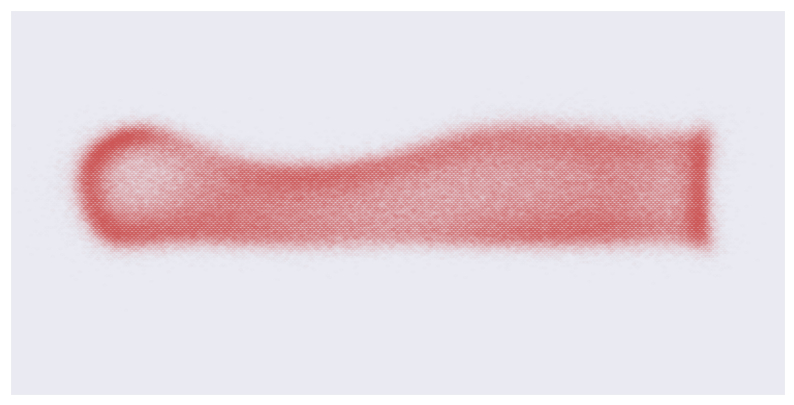